# Success rates vs number of structures for docking

This notebook explores the effect of the number of available structures on cross-docking performance.

In [1]:
from pathlib import Path

from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
sns.set() # Setting seaborn as default style even if use only matplotlib

In [3]:
OUT_DIR = Path("../pics")
OUT_DIR.mkdir(parents=True, exist_ok=True)

In [4]:
fred_results = pd.read_csv("../data/fred_results.csv", index_col=0)
hybrid_results = pd.read_csv("../data/hybrid_results.csv", index_col=0)
posit_results = pd.read_csv("../data/posit_results.csv", index_col=0)

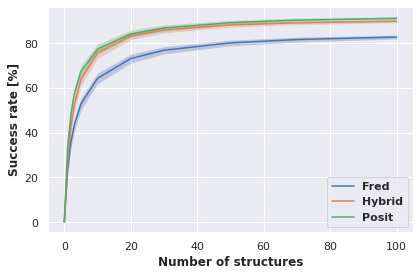

In [5]:
def plot_success_vs_structure_numbers(fred_results, hybrid_results, posit_results, n_bootstrap=1000, ci=0.95, directory=OUT_DIR):
    
    # select pose 1 for Fred and Hybrid, i.e. best pose according to docking score
    fred_results = fred_results[fred_results["pose"] == 1]    
    hybrid_results = hybrid_results[hybrid_results["pose"] == 1]
    
    # sample results
    sampled_success_rates = []
    for method, results in zip(["Fred", "Hybrid", "Posit"], [fred_results, hybrid_results, posit_results]):
        sampled_success_rates.append([0, method, 0, 0, 0])  # origin
        for structure_number in [1, 2, 3, 5, 10, 20, 30, 50, 70, 100]:
            sampled_success_rates_i = []
            for _ in range(n_bootstrap):
                sampled_results = results.groupby("ligand_pdb_id").sample(structure_number, replace=True)
                # sort by rmsd
                sampled_results = sampled_results.sort_values("rmsd")
                # pick the lowest RMSD pose per system
                sampled_results = sampled_results.groupby(["ligand_pdb_id"]).head(1)
                sampled_success_labels = [1 if x <= 2 else 0 for x in sampled_results["rmsd"]]
                sampled_success_rates_i.append(
                    (sum(sampled_success_labels) / len(sampled_success_labels)) * 100
                )
            sampled_success_rates_i = sorted(sampled_success_rates_i)
            mean = sum(sampled_success_rates_i) / len(sampled_success_rates_i)
            cutoff = (1 - ci) / 2
            lower_bound = sampled_success_rates_i[int(n_bootstrap * cutoff)]
            upper_bound = sampled_success_rates_i[int(n_bootstrap * (ci + cutoff))]
            sampled_success_rates.append([structure_number, method, mean, lower_bound, upper_bound])
    sampled_success_rates = pd.DataFrame(
        sampled_success_rates, 
        columns=["n_structures", "method", "success_rate", "ci_lower", "ci_upper"]
    )
    # plot mean
    ax = sns.lineplot(data=sampled_success_rates, x="n_structures", y="success_rate", hue="method", ci=None)
    plt.xlabel("Number of structures", fontweight="bold")
    plt.ylabel("Success rate [%]", fontweight="bold")
    plt.legend(prop=dict(weight="bold"), fancybox=True)
    # plot ci
    ax.fill_between(
        sampled_success_rates[sampled_success_rates["method"] == "Fred"]["n_structures"], 
        sampled_success_rates[sampled_success_rates["method"] == "Fred"]["ci_lower"], 
        sampled_success_rates[sampled_success_rates["method"] == "Fred"]["ci_upper"], 
        alpha=0.3,
        color= ax.get_lines()[0].get_color(),
        linewidth=0
    )
    ax.fill_between(
        sampled_success_rates[sampled_success_rates["method"] == "Hybrid"]["n_structures"], 
        sampled_success_rates[sampled_success_rates["method"] == "Hybrid"]["ci_lower"], 
        sampled_success_rates[sampled_success_rates["method"] == "Hybrid"]["ci_upper"], 
        alpha=0.3,
        color= ax.get_lines()[1].get_color(),
        linewidth=0
    )
    ax.fill_between(
        sampled_success_rates[sampled_success_rates["method"] == "Posit"]["n_structures"], 
        sampled_success_rates[sampled_success_rates["method"] == "Posit"]["ci_lower"], 
        sampled_success_rates[sampled_success_rates["method"] == "Posit"]["ci_upper"], 
        alpha=0.3,
        color= ax.get_lines()[2].get_color(),
        linewidth=0
    )
    plt.tight_layout()
    plt.savefig(directory / "success_vs_structure_number.png", dpi=300)
    
    return sampled_success_rates
    
sampled_success_rates = plot_success_vs_structure_numbers(fred_results, hybrid_results, posit_results)

In [6]:
sampled_success_rates

,n_structures,method,success_rate,ci_lower,ci_upper
0,0,Fred,0.000000,0.000000,0.000000
1,1,Fred,23.773345,21.052632,26.485569
2,2,Fred,35.868591,33.106961,38.879457
3,3,Fred,43.387776,40.407470,46.179966
4,5,Fred,52.853650,50.084890,55.348048
5,10,Fred,64.250934,61.799660,66.553480
6,20,Fred,73.105603,71.137521,75.042445
7,30,Fred,76.825976,75.212224,78.438031
8,50,Fred,80.090662,78.777589,81.324278
9,70,Fred,81.599491,80.475382,82.682513
